#Load Modul

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import numpy as np

#Load Data

In [ ]:
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)

products  = pd.read_excel(xls, sheet_name='Data Product (1000 data)')
users = pd.read_excel(xls, sheet_name='Data User')
orders = pd.read_excel(xls, sheet_name='Data interaction (iseng)')

In [ ]:
orders.head()

,user_id,product_id,rating
0,U001,P008,4
1,U003,P010,4
2,U012,P019,4
3,U017,P021,4
4,U020,P024,5


In [ ]:
orders.head()

,user_id,product_id,rating
0,U001,P008,4
1,U003,P010,4
2,U012,P019,4
3,U017,P021,4
4,U020,P024,5


In [ ]:
products.head()

,product_id,image,product_name,category,color,size,product_price,rent_price,count_num_rating,avg_rating
0,P001,https://docs.google.com/spreadsheets/d/1OzBKFQ...,Basic Linen Kebaya Kutubaru (Long-Sleeve),Adat,Merah,M,116000,17400.0,60,4.4
1,P002,https://images.tokopedia.net/img/cache/200-squ...,Midi Dress Kebaya Wanita Modern Tunik Brukat B...,Adat,Merah,S,195800,29370.0,57,4.7
2,P003,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Batik Encim Malia Lengan Pendek Meradel...,Adat,Putih,XL,189900,28485.0,84,4.9
3,P004,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Kutubaru Clarris Lengan 7/8 Meradelima ...,Adat,Putih,S,219900,32985.0,327,4.1
4,P005,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Kancing Panjang Motif Ayam Garis,Adat,Putih,M,2200000,330000.0,471,4.5


#Collaborative Filltering

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357247 sha256=ac4827b795f0333edbcd45fb2a11c9d7d6815c5182b734ab814314dac8c44d1f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
orders.head()

,user_id,product_id,rating
0,U001,P008,4
1,U003,P010,4
2,U012,P019,4
3,U017,P021,4
4,U020,P024,5


In [ ]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Example order data

# Define the format
reader = Reader(rating_scale=(1, 5))

# Load the data into the Dataset
dataset = Dataset.load_from_df(orders[['user_id', 'product_id', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(dataset, test_size=0.25)

# Instantiate the SVD algorithm
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)

# Test the algorithm on the test set
predictions = algo.test(testset)

# Compute and print RMSE
accuracy.rmse(predictions)


RMSE: 0.5850


0.5850480300797457

In [ ]:
# Function to get top N recommendations for a given user
def get_top_n_recommendations(algo, user_id, items, n=5):
    # Create a list of all item ids
    all_items = items['product_id'].unique()

    # Get items that the user has already rated
    rated_items = items[items['user_id'] == user_id]['product_id'].tolist()

    # Filter out items that the user has already rated
    items_to_predict = [item for item in all_items if item not in rated_items]

    # Predict ratings for all items that the user has not rated
    predictions = [algo.predict(user_id, item) for item in items_to_predict]

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top N items
    top_n_items = [pred.iid for pred in predictions[:n]]

    return top_n_items

# Get top 5 recommendations for user 'U001'
user_id = 'U001'
top_n_recommendations = get_top_n_recommendations(algo, user_id, orders, n=5)

print(f"Top 5 recommendations for user {user_id}: {top_n_recommendations}")


Top 5 recommendations for user U001: ['P980', 'P122', 'P632', 'P713', 'P306']


#Content Based simple version

In [ ]:
products['product_name'].head(5)

0            Basic Linen Kebaya Kutubaru (Long-Sleeve)
1    Midi Dress Kebaya Wanita Modern Tunik Brukat B...
2    Kebaya Batik Encim Malia Lengan Pendek Meradel...
3    Kebaya Kutubaru Clarris Lengan 7/8 Meradelima ...
4              Kebaya Kancing Panjang Motif Ayam Garis
Name: product_name, dtype: object

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
products['product_name'] = products['product_name'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(products['product_name'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1063, 2128)

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(products.index, index=products['product_name']).drop_duplicates()

In [ ]:
# Function that takes in item product_name as input and outputs most similar items
def get_recommendations(product_name, cosine_sim=cosine_sim):
    # Get the index of the item that matches the product_name
    idx = indices[product_name]

    # Get the pairwsie similarity scores of all items with that item
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the items based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar items
    sim_scores = sim_scores[1:11]

    # Get the item indices
    item_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar items
    return products['product_name'].iloc[item_indices]

In [ ]:
get_recommendations('Basic Linen Kebaya Kutubaru (Long-Sleeve)')

32     Kebaya Batik Kutubaru 2 in 1 Lengan 7/8 Merade...
6      Kebaya kutubaru clara lengan panjang meradelim...
511    LINEN DRESS long midcalf belt dress / Linen lo...
525    Deep Hijau Linen Dress with Belt and Pockets, ...
25     Kebaya kutubaru clara lengan panjang meradelim...
491    Black Linen Dress/Party Dress/Open Back Linen ...
12     Kebaya Batik Kutubaru 2 in 1 Lengan Pendek Mer...
16     Kebaya kutubaru rosea lengan 7/8 meradelima ka...
3      Kebaya Kutubaru Clarris Lengan 7/8 Meradelima ...
17     Kebaya kutubaru rosea lengan 7/8 meradelima ka...
Name: product_name, dtype: object

In [ ]:
get_recommendations('Men Linen Suits Sets for Beach Wedding 2 Piece Tuxedo Blazer & Shorts Set for Big and Tall JXZ021')

974     Men's Linen Suit 2 Piece Suits Vest Pants Set,...
996     AMY ZHU Men's Suit 2-Piece Regular Fit Big and...
140     Men's 3 Pieces Linen Suit Casual Slim Fit Suit...
122     Men's Linen 2 Piece Suit Slim Fit Wedding Groo...
1018    Men's Linen 2 Piece Suit Slim Fit Wedding Groo...
1022    Men's Linen 2 Piece Suit Slim Fit Wedding Groo...
966     Mens 2 Piece Suit Slim Fit Business Wedding Pa...
969     COOFANDY Men's 2 Piece Suits Classic Fit 2 But...
146     Men's Tuxedo Suit 3 Piece Slim Fit Tuxedo for ...
1009    Mgnaie Tuxedo Suits for Men 2 Piece Regular Fi...
Name: product_name, dtype: object

#Content Based Filltering

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
orders = pd.read_excel(xls, sheet_name='Data interaction (iseng)')

# Prepare data
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

orders['user_id'] = user_encoder.fit_transform(orders['user_id'])
orders['product_id'] = product_encoder.fit_transform(orders['product_id'])

# Split data into train and test sets
train_data, test_data = train_test_split(orders, test_size=0.2, random_state=42)

# Define embedding sizes
embedding_size = 50  # You can adjust this value based on your dataset and requirements

# Define input layers
user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
product_input = tf.keras.layers.Input(shape=(1,), name='product_input')

# Define embedding layers
user_embedding = tf.keras.layers.Embedding(input_dim=len(user_encoder.classes_),
                                           output_dim=embedding_size,
                                           input_length=1,
                                           name='user_embedding')(user_input)
product_embedding = tf.keras.layers.Embedding(input_dim=len(product_encoder.classes_),
                                              output_dim=embedding_size,
                                              input_length=1,
                                              name='product_embedding')(product_input)

# Reshape embeddings
user_embedding = tf.keras.layers.Reshape(target_shape=(embedding_size,))(user_embedding)
product_embedding = tf.keras.layers.Reshape(target_shape=(embedding_size,))(product_embedding)

# Concatenate user and product embeddings
concat = tf.keras.layers.Concatenate()([user_embedding, product_embedding])

# Define neural network layers
dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
output = tf.keras.layers.Dense(1, activation='linear')(dense2)

# Define model
model = tf.keras.Model(inputs=[user_input, product_input], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

# Train model
history = model.fit([train_data['user_id'], train_data['product_id']], train_data['rating'],
                    batch_size=64, epochs=10, validation_split=0.2)

# Evaluate model
test_loss = model.evaluate([test_data['user_id'], test_data['product_id']], test_data['rating'])
print("Test Loss:", test_loss)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 product_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                5000      ['user_input[0][0]']          
                                                                                                  
 product_embedding (Embeddi  (None, 1, 50)                53150     ['product_input[0][0]']       
 ng)                                                                                          

In [ ]:
# Get all unique product IDs
all_products = orders['product_id'].unique()

# Create a DataFrame to store predicted ratings for user 'U001'
user_id = user_encoder.transform(['U001'])[0]
user_products = pd.DataFrame({'user_id': [user_id]*len(all_products), 'product_id': all_products})

# Predict ratings for user 'U001' and all products
predicted_ratings = model.predict([user_products['user_id'], user_products['product_id']])

# Add predicted ratings to the DataFrame
user_products['predicted_rating'] = predicted_ratings

# Sort products by predicted rating in descending order
user_products_sorted = user_products.sort_values(by='predicted_rating', ascending=False)

# Get top 5 recommendations
top_5_recommendations = user_products_sorted.head(10)

# Convert product IDs back to original labels
top_5_recommendations['product_id'] = product_encoder.inverse_transform(top_5_recommendations['product_id'])

print("Top 5 recommendations for user 'U001':")
print(top_5_recommendations[['product_id', 'predicted_rating']])


34/34 [==============================] - 0s 1ms/step
Top 5 recommendations for user 'U001':
     product_id  predicted_rating
36        P1032          5.314555
488        P636          4.989471
1017       P698          4.981168
1043       P875          4.957954
720        P346          4.952275
663        P160          4.948705
827        P759          4.947325
44         P110          4.946822
451        P488          4.943624
372        P094          4.941679


<ipython-input-26-dbcc5fe3838f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_recommendations['product_id'] = product_encoder.inverse_transform(top_5_recommendations['product_id'])


user u001 pernah order ini :
P008
P100
P134
P187
P234
P289
P345
P419
P469
P523
P603
P707
P809
P908

Top 5 recommendations for user 'U001':
     product_id  predicted_rating
36        P1032          5.033265
1054       P947          4.862140
663        P160          4.821946
529        P776          4.819131
578        P938          4.819036
969        P376          4.802349
720        P346          4.796122
7          P036          4.766222
752        P507          4.721550
795        P655  

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
products = pd.read_excel(xls, sheet_name='Data Product (1000 data)')

# Preprocess data
products['product_name'] = products['product_name'].fillna('')
products['category'] = products['category'].fillna('')

# Combine text features into a single feature
products['features'] = products['product_name'] + ' ' + products['category']

# Vectorize features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['features'])

# Calculate similarity scores (cosine similarity)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get top N recommendations for a given product ID
def get_top_n_recommendations(product_id, similarity_matrix, n=5):
    idx = products.index[products['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    product_indices = [i[0] for i in sim_scores]
    return products['product_id'].iloc[product_indices]

# Get top 5 recommendations for a product with ID 'P001'
top_5_recommendations = get_top_n_recommendations('P001', cosine_sim)
print("Top 5 recommendations for product 'P001':")
print(top_5_recommendations)


Top 5 recommendations for product 'P001':
32     P033
6      P007
235    P169
25     P026
16     P017
Name: product_id, dtype: object


In [ ]:
products.head()

,product_id,image,product_name,category,color,size,product_price,rent_price,count_num_rating,avg_rating,features
0,P001,https://docs.google.com/spreadsheets/d/1OzBKFQ...,Basic Linen Kebaya Kutubaru (Long-Sleeve),Adat,Merah,M,116000,17400.0,60,4.4,Basic Linen Kebaya Kutubaru (Long-Sleeve) Adat
1,P002,https://images.tokopedia.net/img/cache/200-squ...,Midi Dress Kebaya Wanita Modern Tunik Brukat B...,Adat,Merah,S,195800,29370.0,57,4.7,Midi Dress Kebaya Wanita Modern Tunik Brukat B...
2,P003,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Batik Encim Malia Lengan Pendek Meradel...,Adat,Putih,XL,189900,28485.0,84,4.9,Kebaya Batik Encim Malia Lengan Pendek Meradel...
3,P004,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Kutubaru Clarris Lengan 7/8 Meradelima ...,Adat,Putih,S,219900,32985.0,327,4.1,Kebaya Kutubaru Clarris Lengan 7/8 Meradelima ...
4,P005,https://images.tokopedia.net/img/cache/200-squ...,Kebaya Kancing Panjang Motif Ayam Garis,Adat,Putih,M,2200000,330000.0,471,4.5,Kebaya Kancing Panjang Motif Ayam Garis Adat


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        1063 non-null   object 
 1   image             1063 non-null   object 
 2   product_name      1063 non-null   object 
 3   category          1063 non-null   object 
 4   color             1063 non-null   object 
 5   size              1063 non-null   object 
 6   product_price     1063 non-null   object 
 7   rent_price        1063 non-null   float64
 8   count_num_rating  1063 non-null   int64  
 9   avg_rating        1063 non-null   float64
 10  features          1063 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 91.5+ KB


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
products = pd.read_excel(xls, sheet_name='Data Product (1000 data)')

# Preprocess data
products['product_name'] = products['product_name'].fillna('')
products['category'] = products['category'].fillna('')

# Combine text features into a single feature
products['features'] = products['product_name'] + ' ' + products['category']

# Vectorize features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['features'])

# Calculate similarity scores (cosine similarity)
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tfidf_vectorizer.vocabulary_), output_dim=128, input_length=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(products), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train model
model.fit(np.arange(len(products)), products.index, epochs=10, batch_size=64)

# Function to get top N recommendations for a given product ID
def get_top_n_recommendations(product_id, similarity_matrix, n=5):
    idx = products.index[products['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    product_indices = [i[0] for i in sim_scores]
    return products['product_id'].iloc[product_indices]

# Get top 5 recommendations for a product with ID 'P001'
top_5_recommendations = get_top_n_recommendations('P001', similarity_matrix)
print("Top 5 recommendations for product 'P001':")
print(top_5_recommendations)


Epoch 1/10
17/17 [==============================] - 1s 29ms/step - loss: 6.9735
Epoch 2/10
17/17 [==============================] - 0s 27ms/step - loss: 6.9582
Epoch 3/10
17/17 [==============================] - 1s 28ms/step - loss: 6.9366
Epoch 4/10
17/17 [==============================] - 1s 29ms/step - loss: 6.8896
Epoch 5/10
17/17 [==============================] - 1s 40ms/step - loss: 6.7964
Epoch 6/10
17/17 [==============================] - 1s 46ms/step - loss: 6.6170
Epoch 7/10
17/17 [==============================] - 1s 55ms/step - loss: 6.2921
Epoch 8/10
17/17 [==============================] - 1s 59ms/step - loss: 5.7646
Epoch 9/10
17/17 [==============================] - 1s 55ms/step - loss: 4.9956
Epoch 10/10
17/17 [==============================] - 1s 65ms/step - loss: 3.9777
Top 5 recommendations for product 'P001':
32     P033
6      P007
235    P169
25     P026
16     P017
Name: product_id, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
products = pd.read_excel(xls, sheet_name='Data Product (1000 data)')

# Preprocess data
products['product_name'] = products['product_name'].fillna('')
products['category'] = products['category'].fillna('')
products['color'] = products['color'].fillna('')
products['size'] = products['size'].fillna('')
products['product_price'] = products['product_price'].fillna(0).astype(str)
products['rent_price'] = products['rent_price'].fillna(0).astype(float)
products['count_num_rating'] = products['count_num_rating'].fillna(0).astype(int)
products['avg_rating'] = products['avg_rating'].fillna(0).astype(float)

# Combine text and numerical features into a single feature
products['features'] = (products['product_name'] + ' ' +
                        products['category'] + ' ' +
                        products['color'] + ' ' +
                        products['size'] + ' ' +
                        products['product_price'] + ' ' +
                        products['rent_price'].astype(str) + ' ' +
                        products['count_num_rating'].astype(str) + ' ' +
                        products['avg_rating'].astype(str))

# Vectorize features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['features'])

# Scale numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(products[['rent_price', 'count_num_rating', 'avg_rating']])

# Combine TF-IDF matrix and scaled numerical features
features_matrix = np.hstack((tfidf_matrix.toarray(), numerical_features))

# Calculate similarity scores (cosine similarity)
similarity_matrix = cosine_similarity(features_matrix, features_matrix)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(features_matrix.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(products), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train model
model.fit(features_matrix, products.index, epochs=10, batch_size=64)

# Function to get top N recommendations for a given product ID
def get_top_n_recommendations(product_id, similarity_matrix, n=5):
    idx = products.index[products['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    product_indices = [i[0] for i in sim_scores]
    return products['product_id'].iloc[product_indices]

# Get top 5 recommendations for a product with ID 'P001'
top_5_recommendations = get_top_n_recommendations('P001', similarity_matrix)
print("Top 5 recommendations for product 'P001':")
print(top_5_recommendations)


Epoch 1/10
17/17 [==============================] - 2s 55ms/step - loss: 6.9736
Epoch 2/10
17/17 [==============================] - 1s 51ms/step - loss: 6.9560
Epoch 3/10
17/17 [==============================] - 1s 50ms/step - loss: 6.9242
Epoch 4/10
17/17 [==============================] - 1s 45ms/step - loss: 6.8370
Epoch 5/10
17/17 [==============================] - 1s 46ms/step - loss: 6.6337
Epoch 6/10
17/17 [==============================] - 1s 46ms/step - loss: 6.2870
Epoch 7/10
17/17 [==============================] - 1s 55ms/step - loss: 5.8697
Epoch 8/10
17/17 [==============================] - 1s 75ms/step - loss: 5.4593
Epoch 9/10
17/17 [==============================] - 1s 80ms/step - loss: 5.0512
Epoch 10/10
17/17 [==============================] - 1s 64ms/step - loss: 4.6488
Top 5 recommendations for product 'P001':
799    P735
853    P789
235    P169
27     P028
32     P033
Name: product_id, dtype: object


WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.
Epoch 1/10
17/17 [==============================] - 1s 38ms/step - loss: 6.9740
Epoch 2/10
17/17 [==============================] - 1s 57ms/step - loss: 6.9561
Epoch 3/10
17/17 [==============================] - 1s 65ms/step - loss: 6.9255
Epoch 4/10
17/17 [==============================] - 1s 76ms/step - loss: 6.8395
Epoch 5/10
17/17 [==============================] - 1s 77ms/step - loss: 6.6459
Epoch 6/10
17/17 [==============================] - 1s 84ms/step - loss: 6.3146
Epoch 7/10
17/17 [==============================] - 1s 57ms/step - loss: 5.9182
Epoch 8/10
17/17 [==============================] - 1s 66ms/step - loss: 5.5123
Epoch 9/10
17/17 [==============================] - 1s 53ms/step - loss: 5.0933
Epoch 10/10
17/17 [==============================] - 1s 47ms/step - loss: 4.6727
Top 5 recommendations for product 'P001':
799    P735
853    P789
235    P169
27     P028
32     P033
Name: product_id, dtype: object


```
P001,,Basic Linen Kebaya Kutubaru (Long-Sleeve),Adat,Merah,M,Rp116.000,"Rp17.400,00",60,"4,4"
```

```
P735,,ZooBoo Traditional Long Sleeve Tang Kung Fu Uniform Men's Shirt,Adat,Abu-Abu,L,"Rp400,000","Rp60,000",13,"4,4"
```

```
P789,,GRACE KARIN Women's 2024 Floral Summer Long Midi Dress,Pesta,Merah Muda,L,"Rp704,000","Rp105,600",60,"4,4"
```

```
P169,,Kebaya Lurik Kutubaru Setelan Anak Perempuan+ Rok Jarik Baju Adat Jawa,Adat,Merah,L,Rp159.561,"Rp23.934,18",75,"4,4"
```

```
P028,,KEBAYA KUTUBARU KLASIK BLUDRU ANGKIN JUMPUTAN,Adat,Biru,S,Rp186.000,"Rp27.900,00",98,"4,5"
```

```
P033,,Kebaya Batik Kutubaru 2 in 1 Lengan 7/8 Meradelima Katun Hitam,Adat,Hitam,M,Rp219.900,"Rp32.985,00",40,"4,7"
```


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
products = pd.read_excel(xls, sheet_name='Data Product (1000 data)')

# Preprocess data
products['product_name'] = products['product_name'].fillna('')
products['category'] = products['category'].fillna('')
products['color'] = products['color'].fillna('')
products['size'] = products['size'].fillna('')
products['product_price'] = products['product_price'].fillna(0).astype(str)
products['rent_price'] = products['rent_price'].fillna(0).astype(float)
products['count_num_rating'] = products['count_num_rating'].fillna(0).astype(int)
products['avg_rating'] = products['avg_rating'].fillna(0).astype(float)

# Combine text and numerical features into a single feature
products['features'] = (products['product_name'] + ' ' +
                        products['category'] + ' ' +
                        products['color'] + ' ' +
                        products['size'] + ' ' +
                        products['product_price'].astype(str) + ' ' +
                        products['rent_price'].astype(str) + ' ' +
                        products['count_num_rating'].astype(str) + ' ' +
                        products['avg_rating'].astype(str))

# Vectorize features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['features'])

# Scale numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(products[['rent_price', 'count_num_rating', 'avg_rating']])

# Combine TF-IDF matrix and scaled numerical features
features_matrix = np.hstack((tfidf_matrix.toarray(), numerical_features))

# Calculate similarity scores (cosine similarity)
similarity_matrix = cosine_similarity(features_matrix, features_matrix)

# Define model with more layers
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(features_matrix.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(products), activation='softmax')
])

# Compile model with different optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train model with more epochs
history = model.fit(features_matrix, products.index, epochs=100, batch_size=64)

# Evaluate model on training data
loss, accuracy = model.evaluate(features_matrix, products.index)
print("Final Loss:", loss)
print("Final Accuracy:", accuracy)

# Function to get top N recommendations for a given product ID
def get_top_n_recommendations(product_id, similarity_matrix, n=5):
    idx = products.index[products['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    product_indices = [i[0] for i in sim_scores]
    return products['product_id'].iloc[product_indices]

# Get top 5 recommendations for a product with ID 'P001'
top_5_recommendations = get_top_n_recommendations('P001', similarity_matrix)
print("Top 5 recommendations for product 'P001':")
print(top_5_recommendations)

Epoch 1/100
17/17 [==============================] - 7s 67ms/step - loss: 6.9737 - accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 1s 65ms/step - loss: 6.9632 - accuracy: 0.0056
Epoch 3/100
17/17 [==============================] - 1s 60ms/step - loss: 6.9415 - accuracy: 0.0066
Epoch 4/100
17/17 [==============================] - 1s 66ms/step - loss: 6.8541 - accuracy: 0.0056
Epoch 5/100
17/17 [==============================] - 1s 57ms/step - loss: 6.6230 - accuracy: 0.0056
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 6.2967 - accuracy: 0.0038
Epoch 7/100
17/17 [==============================] - 1s 58ms/step - loss: 5.9803 - accuracy: 0.0103
Epoch 8/100
17/17 [==============================] - 1s 69ms/step - loss: 5.6221 - accuracy: 0.0160
Epoch 9/100
17/17 [==============================] - 1s 61ms/step - loss: 5.3024 - accuracy: 0.0301
Epoch 10/100
17/17 [==============================] - 2s 91ms/step - loss: 4.9755 - accuracy: 0.

34/34 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9906
Final Loss: 0.020713364705443382
Final Accuracy: 0.9905926585197449
Top 5 recommendations for product 'P001':
799    P735
853    P789
235    P169
27     P028
32     P033
Name: product_id, dtype: object


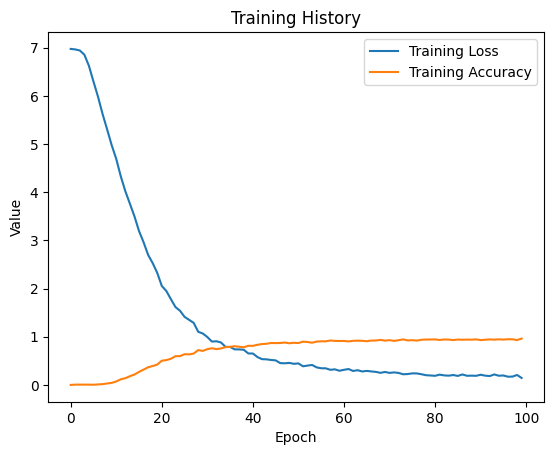

In [ ]:
# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()
plt.show()

In [ ]:
# Get top 5 recommendations for a product with ID 'P002'
top_5_recommendations = get_top_n_recommendations('P002', similarity_matrix)
print("Top 5 recommendations for product 'P002':")
print(top_5_recommendations)

Top 5 recommendations for product 'P002':
477    P412
794    P730
466    P401
798    P734
433    P368
Name: product_id, dtype: object



```
P002,,Midi Dress Kebaya Wanita Modern Tunik Brukat Bahan Tille Full Furing,Adat,Merah,S,Rp195.800,"Rp29.370,00",57,"4,7"
```

```
P412,,Long Coat blazer panjang wanita Korean style,Formal,Merah,XL,Rp140.650,"Rp21.097,50",10,"5,0"
```

```
P730,,DLSNZ Men's Traditional Chinese Kung Fu Clothing Hanfu & Tang Suit Martial Arts Coats,Adat,Merah,M,"Rp576,000","Rp86,400",1,"5,0"
```

```
P401,,ROMPI WANITA/OUTFIT WANITA 2023,Formal,Merah,L,Rp140.000,"Rp21.000,00",58,"4,9"
```

```
P734,,Kung Fu Tops Uniform Tang Men Chinese Traditional Clothing Hanfu Martial Arts,Adat,Hitam,M,"Rp800,000","Rp120,000",3,"5,0"
```

```
P368,,Blazer wanita Korea Poket Blezer Long Coat Wanita panjang,Formal,Merah,M,Rp190.000,"Rp28.500,00",4,"4,9"
```


In [ ]:
# Get top 5 recommendations for a product with ID 'P1000'
top_5_recommendations = get_top_n_recommendations('P1000', similarity_matrix)
print("Top 5 recommendations for product 'P1000':")
print(top_5_recommendations)

Top 5 recommendations for product 'P1000':
1046     P983
141     P1038
976      P913
103     P1003
109     P1009
Name: product_id, dtype: object


In [ ]:
# Get top 5 recommendations for a product with ID 'P100'
top_5_recommendations = get_top_n_recommendations('P100', similarity_matrix)
print("Top 5 recommendations for product 'P100':")
print(top_5_recommendations)

Top 5 recommendations for product 'P100':
88     P089
90     P091
87     P088
713    P649
654    P589
Name: product_id, dtype: object


In [ ]:
# Save model
model.save('/content/saved_model')

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to file
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Load data
file_path = '/content/Data Collection.xlsx'
xls = pd.ExcelFile(file_path)
products = pd.read_excel(xls, sheet_name='Data Product (1000 data)')

# Preprocess data
products['product_name'] = products['product_name'].fillna('')
products['category'] = products['category'].fillna('')
products['color'] = products['color'].fillna('')
products['size'] = products['size'].fillna('')
products['product_price'] = products['product_price'].str.replace('Rp', '').str.replace(',', '').astype(float)
products['rent_price'] = products['rent_price'].fillna(0).astype(float)
products['count_num_rating'] = products['count_num_rating'].fillna(0).astype(int)
products['avg_rating'] = products['avg_rating'].fillna(0).astype(float)

# Combine text and numerical features into a single feature
products['features'] = (products['product_name'] + ' ' +
                        products['category'] + ' ' +
                        products['color'] + ' ' +
                        products['size'] + ' ' +
                        products['product_price'].astype(str) + ' ' +
                        products['rent_price'].astype(str) + ' ' +
                        products['count_num_rating'].astype(str) + ' ' +
                        products['avg_rating'].astype(str))

# Vectorize features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(products['features'])

# Scale numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(products[['rent_price', 'count_num_rating', 'avg_rating']])

# Combine TF-IDF matrix and scaled numerical features
features_matrix = np.hstack((tfidf_matrix.toarray(), numerical_features))

# Save products and features matrix
products[['product_id', 'product_name']].to_csv('products.csv', index=False)
np.savetxt('features_matrix.csv', features_matrix, delimiter=',')